# Unsupervised learning

In [1]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
import pandas as pd

# PCA example with diabetes dataset

In [3]:
# we will use pandas to display the data nicely
datasource = pd.read_csv('http://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', delimiter='\t')
datasource.columns = ['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu', 'disease_progression']
diabetes_df = spark.createDataFrame(datasource)

In [4]:
diabetes_df

DataFrame[age: bigint, sex: bigint, bmi: double, map: double, tc: bigint, ldl: double, hdl: double, tch: double, ltg: double, glu: bigint, disease_progression: bigint]

## Build a pipeline

In [5]:
pipeline_diabetes = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'
                          ),
    feature.PCA(k=2, inputCol='zfeatures', outputCol='loadings')
]).fit(diabetes_df)

In [6]:
principal_components = pipeline_diabetes.stages[-1].pc.toArray()

In [7]:
principal_components

array([[-0.2164309 ,  0.04436721],
       [-0.18696688, -0.3865472 ],
       [-0.30316216, -0.15628128],
       [-0.27173773, -0.138266  ],
       [-0.34325511,  0.57302691],
       [-0.35186068,  0.45594185],
       [ 0.28243681,  0.50623907],
       [-0.4288337 , -0.06818072],
       [-0.37861802, -0.026187  ],
       [-0.32218296, -0.08494884]])

In [8]:
pipeline_diabetes.transform(diabetes_df).select('zfeatures', 'loadings').first()

Row(zfeatures=DenseVector([0.7996, 1.0643, 1.2956, 0.4593, -0.9287, -0.7312, -0.9114, -0.0544, 0.4181, -0.3706]), loadings=DenseVector([-0.5865, -1.9446]))

In [9]:
z = pipeline_diabetes.transform(diabetes_df).select('zfeatures', 'loadings').first()['zfeatures']

In [10]:
z.dot(principal_components)

array([-0.5865345 , -1.94462866])

## Examine the principal components

In [11]:
list(zip(['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'], 
         principal_components[:, 0], principal_components[:, 1]))

[('age', -0.21643089648897473, 0.044367212393233844),
 ('sex', -0.18696687908602555, -0.3865472038551628),
 ('bmi', -0.30316216313887745, -0.15628128429437474),
 ('map', -0.2717377304844055, -0.13826600177995474),
 ('tc', -0.3432551083789176, 0.5730269088415814),
 ('ldl', -0.3518606824177598, 0.4559418547240137),
 ('hdl', 0.28243681319974884, 0.5062390689011844),
 ('tch', -0.4288336980133311, -0.06818071604588977),
 ('ltg', -0.3786180159906992, -0.026186995954152602),
 ('glu', -0.3221829550849705, -0.08494884202867298)]

# Analysis of IM courses

In [12]:
im_courses = spark.createDataFrame(pd.read_csv('https://github.com/daniel-acuna/data_science_programs/raw/master/data/im_masters_ischool.csv'))

In [13]:
im_courses.show()

+-------+----+-------+--------------------+--------------------+
| course|core|credits|               title|         description|
+-------+----+-------+--------------------+--------------------+
|IST 553|  IM|      3|Information Archi...|Building and mana...|
|IST 558| CAS|      3|Technologies in W...|Concepts and tech...|
|IST 565| CAS|      3|         Data Mining|Introduction to d...|
|IST 601|  IM|      3|Information and I...|A broad overview ...|
|IST 614|  IM|      3|Management Princi...|Basic ideas, conc...|
|IST 617|  IM|      3|Motivational Aspe...|Theories of motiv...|
|IST 618|  IM|      3|  Information Policy|Public policy iss...|
|IST 619|  IM|      3|Applied Economics...|Economic principl...|
|IST 621|  IM|      3|Introduction to I...|Overview of gener...|
|IST 631|  IM|      3|Theory of Classif...|Classification is...|
|IST 639|  IM|      3|Enterprise Techno...|Coverage of manag...|
|IST 641|  IM|      3|   User-Based Design|System design bas...|
|IST 645|  IM|      3|Man

## Let's transform course descriptions into vectors

In [14]:
tokenizer = feature.RegexTokenizer(minTokenLength=2)\
  .setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("description")\
  .setOutputCol("words")

import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

sw_filter = feature.StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = feature.CountVectorizer(inputCol='filtered', outputCol='tf')
idf = feature.IDF(inputCol='tf', outputCol='tfidf')

The rest of the functions does not work with Sparse vectors. We need to create a UDF that performs a sparse to dense transformation

Let's create a pipeline that transforms descriptions into TFIDF:

In [15]:
tfidf = Pipeline(stages=[tokenizer, sw_filter, cv, idf]).fit(im_courses)

In [16]:
tfidf.transform(im_courses).show()

+-------+----+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| course|core|credits|               title|         description|               words|            filtered|                  tf|               tfidf|
+-------+----+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|IST 553|  IM|      3|Information Archi...|Building and mana...|[building, and, m...|[building, manage...|(357,[0,1,9,12,14...|(357,[0,1,9,12,14...|
|IST 558| CAS|      3|Technologies in W...|Concepts and tech...|[concepts, and, t...|[concepts, techni...|(357,[1,2,3,4,16,...|(357,[1,2,3,4,16,...|
|IST 565| CAS|      3|         Data Mining|Introduction to d...|[introduction, to...|[introduction, da...|(357,[2,3,8,22,24...|(357,[2,3,8,22,24...|
|IST 601|  IM|      3|Information and I...|A broad overview ...|[broad, overview,...|[broad, overview,...|

We need to define a *Python* function that takes as input a column from `tfidf` and then returns the dense version of it.
If we get the first row of the transformation, we can examine the type of `tfidf`

In [17]:
tfidf_sample = tfidf.transform(im_courses).first().tfidf

In [18]:
tfidf_sample

SparseVector(357, {0: 1.8572, 1: 1.4443, 9: 3.2189, 12: 1.6094, 14: 1.7636, 16: 1.7636, 32: 2.1691, 50: 2.1691, 60: 2.1691, 66: 2.4567, 72: 2.4567, 87: 5.7244, 173: 2.8622, 333: 2.8622, 352: 2.8622})

In [19]:
type(tfidf_sample)

pyspark.ml.linalg.SparseVector

We need to define a function that returns a dense version. For that, we will make use of the Vectors class

In [20]:
from pyspark.ml.linalg import Vectors

In [21]:
Vectors.dense(tfidf_sample)

DenseVector([1.8572, 1.4443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2189, 0.0, 0.0, 1.6094, 0.0, 1.7636, 0.0, 1.7636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.7244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8622, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [22]:
type(Vectors.dense(tfidf_sample))

pyspark.ml.linalg.DenseVector

We need to work with `pyspark.ml.linalg.DenseVector` because that's what Spark ML expects (as opposed to a Numpy array)

So, let's define the function:

In [23]:
def to_dense(sparse_vector):
    return Vectors.dense(sparse_vector)

In [24]:
to_dense(tfidf_sample)

DenseVector([1.8572, 1.4443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2189, 0.0, 0.0, 1.6094, 0.0, 1.7636, 0.0, 1.7636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.7244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8622, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Now, to define a custom function for Spark SQL, we need to provide the **return** type of the function to the constructor in `functions.udf`. The return type of `to_dense` is `VectorUDT` defined in `pyspark.ml.linalg.VectorUDT`

In [25]:
from pyspark.ml.linalg import VectorUDT

In [26]:
to_dense_udf = fn.udf(to_dense, VectorUDT())

Now we can use this function as part of our transformations

In [27]:
tfidf.transform(im_courses).select('tfidf', to_dense_udf('tfidf').alias('dense_tfidf')).show()

+--------------------+--------------------+
|               tfidf|         dense_tfidf|
+--------------------+--------------------+
|(357,[0,1,9,12,14...|[1.85722243252439...|
|(357,[1,2,3,4,16,...|[0.0,0.7221347174...|
|(357,[2,3,8,22,24...|[0.0,0.0,1.252762...|
|(357,[0,25,40,41,...|[0.92861121626219...|
|(357,[0,1,3,4,7,1...|[0.46430560813109...|
|(357,[0,1,6,12,19...|[1.39291682439329...|
|(357,[0,4,10,11,2...|[0.92861121626219...|
|(357,[0,1,4,5,14,...|[1.39291682439329...|
|(357,[0,1,4,38,41...|[0.46430560813109...|
|(357,[0,26,34,84,...|[0.46430560813109...|
|(357,[1,5,10,24,3...|[0.0,0.7221347174...|
|(357,[0,6,7,12,16...|[0.92861121626219...|
|(357,[0,1,7,8,13,...|[0.46430560813109...|
|(357,[0,6,13,14,1...|[0.46430560813109...|
|(357,[1,5,10,27,4...|[0.0,0.7221347174...|
|(357,[1,3,4,5,8,9...|[0.0,0.7221347174...|
|(357,[0,1,6,9,47,...|[0.46430560813109...|
|(357,[0,5,6,22,24...|[0.92861121626219...|
|(357,[0,1,2,3,4,5...|[0.46430560813109...|
|(357,[0,3,8,28,38...|[1.3929168

Moreover, we want to make this as part of a Pipeline. This is a somewhat obscure and undocumented functionality of Spark. We will now define a simple `Transformer` that will apply the `to_dense_udf` to an input column:

In [28]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param


class Densify(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, stopwords=None):
        super(Densify, self).__init__()
        self._setDefault()
#         print(self._input_kwargs)
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, to_dense_udf(in_col))

In [29]:
dense_tfidf = Densify(inputCol='tfidf', outputCol='dense_tfidf')

In [30]:
pipeline2_model = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf]).fit(im_courses)
pipeline2_model.transform(im_courses).select('tfidf', 'dense_tfidf').show()

+--------------------+--------------------+
|               tfidf|         dense_tfidf|
+--------------------+--------------------+
|(357,[0,1,9,12,14...|[1.85722243252439...|
|(357,[1,2,3,5,16,...|[0.0,0.7221347174...|
|(357,[2,3,8,23,25...|[0.0,0.0,1.252762...|
|(357,[0,24,43,45,...|[0.92861121626219...|
|(357,[0,1,3,5,7,1...|[0.46430560813109...|
|(357,[0,1,6,12,19...|[1.39291682439329...|
|(357,[0,5,10,11,2...|[0.92861121626219...|
|(357,[0,1,4,5,14,...|[1.39291682439329...|
|(357,[0,1,5,44,45...|[0.46430560813109...|
|(357,[0,21,41,67,...|[0.46430560813109...|
|(357,[1,4,10,23,2...|[0.0,0.7221347174...|
|(357,[0,6,7,12,16...|[0.92861121626219...|
|(357,[0,1,7,8,13,...|[0.46430560813109...|
|(357,[0,6,13,14,1...|[0.46430560813109...|
|(357,[1,4,10,25,4...|[0.0,0.7221347174...|
|(357,[1,3,4,5,8,9...|[0.0,0.7221347174...|
|(357,[0,1,6,9,48,...|[0.46430560813109...|
|(357,[0,4,6,23,26...|[0.92861121626219...|
|(357,[0,1,2,3,4,5...|[0.46430560813109...|
|(357,[0,3,8,27,44...|[1.3929168

In [31]:
# standardize features - it doesn't work in Spark 2.1
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='dense_tfidf', outputCol='centered_tfidf')

And we will apply different unsupervised learning mechanisms:

We need to define a custom transformer that takes a sparse vector and returns dense vector

PCA needs the number of principal components to be learned:

In [32]:
pca = feature.PCA(k=10, inputCol='centered_tfidf', outputCol='pca_feat')

KMeans, we need to provide the number of clusters, but we will normalize the vectors so that they have unit length:

In [33]:
norm = feature.Normalizer(inputCol="centered_tfidf", outputCol="norm_tfidf", p=2.0)

In [34]:
kmeans = clustering.KMeans(k=5, featuresCol='norm_tfidf', predictionCol='kmeans_feat')

Latent Dirichlet Allocation needs the number of topics and acts on raw tfidf:

In [35]:
lda = clustering.LDA(k=5, featuresCol='tfidf', topicDistributionCol='lda_feat')

In [36]:
pipeline = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf, center, norm, kmeans, lda, pca])

In [37]:
pipeline_model = pipeline.fit(im_courses)

In [38]:
pipeline_model.transform(im_courses).show(5)

+-------+----+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+
| course|core|credits|               title|         description|               words|            filtered|                  tf|               tfidf|         dense_tfidf|      centered_tfidf|          norm_tfidf|kmeans_feat|            lda_feat|            pca_feat|
+-------+----+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+
|IST 553|  IM|      3|Information Archi...|Building and mana...|[building, and, m...|[building, manage...|(357,[0,1,9,11,13...|(357,[0,1,9,11,13...|[1.85722243252439...|[1.39291682439329...|[0.138728332

In [39]:
pipeline_model.transform(im_courses).select('course', 'pca_feat', 'kmeans_feat', 'lda_feat').show()

+-------+--------------------+-----------+--------------------+
| course|            pca_feat|kmeans_feat|            lda_feat|
+-------+--------------------+-----------+--------------------+
|IST 553|[-0.6752213340342...|          2|[0.11790482599999...|
|IST 558|[-1.0560092197231...|          1|[0.47460797007841...|
|IST 565|[0.19618219422530...|          2|[0.00283682039525...|
|IST 601|[-0.6823791849888...|          4|[0.00514240561516...|
|IST 614|[-1.3508184757797...|          0|[0.00300752575839...|
|IST 617|[-1.0011668423934...|          2|[0.00303504213234...|
|IST 618|[0.07015134336406...|          3|[0.00216943218223...|
|IST 619|[-0.8783462827126...|          2|[0.00299257252940...|
|IST 621|[-0.6168769630891...|          2|[0.00450034382751...|
|IST 631|[-1.1184062933773...|          2|[0.00346499354436...|
|IST 639|[8.23698193178384...|          2|[0.00221154699199...|
|IST 641|[-2.1217616801297...|          1|[0.00271159023735...|
|IST 645|[-1.6269837851599...|          

# Interpreation of the fits 

We can examine the loadings in the PCA:

In [40]:
import pandas as pd

In [41]:
pipeline_model.stages

[RegexTokenizer_4da090bbe0d768cb3cca,
 StopWordsRemover_4abf83d5a9d1b357027d,
 CountVectorizer_494f86c95a127b968410,
 IDF_49eb8022e18b2b9e58bb,
 Densify_4a6c90297de5cc57a12a,
 StandardScaler_47bea520717845e16460,
 Normalizer_446583d8821ec61ac0bc,
 KMeans_4b5a88af9936b3ae1a26,
 LDA_4e03811c47857aa4de45,
 PCA_4419bfe10d5beaf19289]

In [42]:
pca_model = pipeline_model.stages[-1]

In [43]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()
pc3 = pca_model.pc.toArray()[:, 2].tolist()

In [44]:
vocabulary = pipeline_model.stages[2].vocabulary

In [45]:
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2, pc3]).T.rename(columns={0: 'word', 
                                                                          1: 'load_pc1',
                                                                          2: 'load_pc2',
                                                                          3: 'load_pc3',})

In [46]:
# smallest and biggest loadings of pc1
pd.concat((pc_loadings.sort_values('load_pc1').head(), 
           pc_loadings.sort_values('load_pc1').tail()))

,word,load_pc1,load_pc2,load_pc3
44,required,-0.067063,0.0054385,0.0715218
33,processing,-0.0654304,0.00737648,0.0743025
73,computational,-0.0613542,0.00504601,0.0764562
117,linguistic,-0.0613542,0.00504601,0.0764562
6,students,-0.0579638,0.00405441,0.0680286
80,complex,0.188491,-0.051103,0.00445523
63,architecture,0.188491,-0.051103,0.00445523
48,enterprise,0.254813,-0.453853,-0.0290984
20,databases,0.275076,0.199085,0.0735311
27,database,0.538651,0.366988,0.0595601


In [47]:
# smallest and biggest loadings of pc2
pd.concat((pc_loadings.sort_values('load_pc2').head(), 
           pc_loadings.sort_values('load_pc2').tail()))

,word,load_pc1,load_pc2,load_pc3
48,enterprise,0.254813,-0.453853,-0.0290984
96,computing,0.169875,-0.302568,-0.019399
56,large,0.144783,-0.263025,-0.0181318
4,systems,0.0903704,-0.160692,0.0276732
197,technical,0.0849375,-0.151284,-0.00969948
178,reports,0.134663,0.091747,0.01489
99,security,0.116207,0.094556,-0.129068
109,warehouses,0.116554,0.097372,0.0149755
20,databases,0.275076,0.199085,0.0735311
27,database,0.538651,0.366988,0.0595601


In [48]:
# smallest and biggest loadings of pc3
pd.concat((pc_loadings.sort_values('load_pc3').head(), 
           pc_loadings.sort_values('load_pc3').tail()))

,word,load_pc1,load_pc2,load_pc3
131,policy,0.00144676,0.0368293,-0.330519
107,public,0.00144676,0.0368293,-0.330519
45,economic,-0.0149275,0.0125956,-0.184823
263,access,0.000723382,0.0184146,-0.165259
319,expression,0.000723382,0.0184146,-0.165259
126,administration,0.0155463,0.00854415,0.079552
25,modeling,0.00457799,0.00875369,0.0798089
54,projects,-0.0324584,-0.0187311,0.0871006
2,data,0.0864014,0.0851734,0.133236
47,metadata,-0.0223883,-0.0428104,0.194214


# Visualize fit with PCA with 2 dimensions

In [49]:
pipeline2_model = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf, 
                                   feature.Normalizer(inputCol='dense_tfidf', outputCol='norm_tfidf'), 
                                   feature.StandardScaler(withMean=True, withStd=False, 
                                                          inputCol='norm_tfidf',
                                                          outputCol='centered_tfidf'),
                                   feature.PCA(k=2, inputCol='centered_tfidf', outputCol='pca_feat2')])\
    .fit(im_courses)

In [50]:
course_names = np.array(im_courses.select('course').rdd.map(lambda x: x['course']).collect())
X = np.array(pipeline2_model.transform(im_courses).select('pca_feat2').rdd.map(lambda x: x['pca_feat2']).collect())

In [51]:
idx = np.abs(X[:, 0]) < 0.2
X = X[idx]
course_names = course_names[idx]

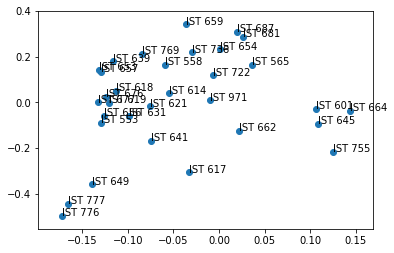

In [52]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])

for i, txt in enumerate(course_names):
    ax.annotate(txt, (X[i,0], X[i,1]))

In [53]:
pca_model = pipeline2_model.stages[-1]

In [54]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()

In [55]:
vocabulary = pipeline2_model.stages[2].vocabulary

In [56]:
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'word', 
                                                                          1: 'load_pc1',
                                                                          2: 'load_pc2'})

In [57]:
pc_loadings.sort_values('load_pc1').\
    apply({'word': lambda x: x, 'load_pc1': np.abs}, axis=0).head(5)

,word,load_pc1
18,research,0.11137
14,digital,0.0683895
6,design,0.0668912
10,issues,0.0572029
60,networks,0.0537774


In [58]:
pc_loadings.sort_values('load_pc2').\
    apply({'word': lambda x: x, 'load_pc2': np.abs}, axis=0).head(5)

,word,load_pc2
18,research,0.346353
42,user,0.175591
70,transfer,0.16139
97,procedures,0.154404
93,practices,0.141174


# Examine LDA

In [59]:
lda_model = pipeline_model.stages[-2]

In [60]:
lda_model.describeTopics(maxTermsPerTopic=2).show()

+-----+-----------+--------------------+
|topic|termIndices|         termWeights|
+-----+-----------+--------------------+
|    0|  [114, 15]|[0.02131339012610...|
|    1|  [38, 110]|[0.03191593532699...|
|    2|   [7, 108]|[0.02246973843947...|
|    3| [107, 131]|[0.01989899489420...|
|    4|    [2, 69]|[0.01817362627580...|
+-----+-----------+--------------------+



In [61]:
# get the terms
terms_matrix = np.array(lda_model.describeTopics(2).rdd.map(lambda x: x['termIndices']).collect())

In [62]:
np.array(vocabulary)[terms_matrix]

array([['warehouses', 'organization'],
       ['using', 'visualization'],
       ['students', 'policy'],
       ['case', 'solution'],
       ['data', 'theories']], dtype='<U18')

In [63]:
# which topic best describes IST 718
pipeline_model.transform(im_courses).where("course == 'IST 718'").first()['lda_feat']

DenseVector([0.0041, 0.0039, 0.0047, 0.0042, 0.9831])

# Examine K-means

In [64]:
pipeline_model.transform(im_courses).\
    groupBy('kmeans_feat').agg(fn.collect_list(
    fn.concat_ws('-', fn.col('course'), fn.col('title'))).alias('courses')).toPandas().values

array([[1,
        list(['IST 558-Technologies in Web Content Management', 'IST 641-User-Based Design', 'IST 656-Telecommunications and Enterprise Network Management II'])],
       [3,
        list(['IST 618-Information Policy', 'IST 659-Data Administration Concepts and Database Management', 'IST 722-Data Warehouse', 'IST 769-Advanced Database Administration Concepts and Database Management'])],
       [4,
        list(['IST 601-Information and Information Environments', 'IST 681-Metadata', 'IST 687-Applied Data Science', 'IST 718-Advanced Information Analytics', 'IST 719-Information Visualization'])],
       [2,
        list(['IST 553-Information Architecture for Internet Services', 'IST 565-Data Mining', 'IST 617-Motivational Aspects of Information Use', 'IST 619-Applied Economics for Information Managers', 'IST 621-Introduction to Information Management', 'IST 631-Theory of Classification and Subject Representation', 'IST 639-Enterprise Technologies', 'IST 653-Telecommunications and


# Make recommendations

To make recommendations, we need compute the distance between a vector and all the other courses in our dataset. To do this, we need to define a User Defined Function (UDF) that takes as input two column vectors and returns the distance between them.

In [65]:
from pyspark.sql import types

In [66]:
import numpy as np
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

Let's take the PCA features of IST 718.

In [67]:
l2_dist_udf = fn.udf(l2_dist, types.FloatType())

Spark doesn't allow a join without a condition because it could be too computationally expensive. We have to enable it by running the following command

In [68]:
spark.sql("SET spark.sql.crossJoin.enabled=TRUE").show()

+--------------------+-----+
|                 key|value|
+--------------------+-----+
|spark.sql.crossJo...| TRUE|
+--------------------+-----+



In [69]:
pipeline_model.transform(im_courses).\
    where('course == "IST 718"').\
    select(fn.col("pca_feat").alias('query_feat')).\
    join(pipeline_model.transform(im_courses)).\
    withColumn('dist', l2_dist_udf('pca_feat', 'query_feat')).\
    select("course", "description", "dist").\
    orderBy(fn.asc("dist")).\
    limit(5).\
    toPandas()

,course,description,dist
0,IST 718,A broad introduction to analytical processing ...,0.000000
1,IST 719,A broad introduction to data visualization for...,1.466475
2,IST 565,"Introduction to data mining techniques, famili...",4.206517
3,IST 662,Introduction to information literacy models fo...,4.281012
4,IST 601,A broad overview of the field and an orientati...,4.523474
